# Bayesian Model Averaging Using the BIC

## Fitting a Uniform Distribution

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

# Data
y = [2, 3, 7, 8, 4, 5, 10, 15, 8, 6, 3, 11]

# Calculate the mean of the data (MLE for lambda in Poisson distribution)
mean_y = np.mean(y)
variance_y = np.var(y)

def fit_uniform(y):
    # Define the Uniform distribution PMF
    def uniform_pmf(k, n):
        k = np.asarray(k)  # Ensure k is a numpy array
        return [1 / n if j <= n else 0 for j in k]

    # Define the negative log-likelihood function for the Uniform distribution
    def neg_log_likelihood_uniform(params, data):
        n = params[0]  # Assuming n is the number of trials in the data
        pmf_values = uniform_pmf(data, n)
        # Avoid log(0) by replacing 0 with a very small number
        pmf_values = np.where(np.array(pmf_values) == 0, 1e-10, pmf_values)
        return -np.sum(np.log(pmf_values))

    n_range = range(1,np.max(y)*10)

    # Grid search for the best n
    best_n = None
    best_neg_log_likelihood = np.inf

    for n in n_range:
        # Initial guess for n
        initial_guess = np.array([n])
        # Minimize the negative log-likelihood
        result = minimize(neg_log_likelihood_uniform, initial_guess, args=(y,), bounds=[(1e-5, None)])

        if result.fun < best_neg_log_likelihood:
            best_neg_log_likelihood = result.fun
            best_n = result.x[0]

    # Extract the fitted parameter
    n_fitted = best_n

    # Calculate the log-likelihood of the model
    log_likelihood_uniform = -neg_log_likelihood_uniform([n_fitted], y)

    # Number of parameters (k) and number of data points (n)
    k = 1
    n = len(y)

    # Calculate BIC
    bic_uniform = k * np.log(n) - 2 * log_likelihood_uniform

    return log_likelihood_uniform, n_fitted, bic_uniform, uniform_pmf, neg_log_likelihood_uniform

log_likelihood_uniform, n_fitted_uniform, bic_uniform, uniform_pmf, _ = fit_uniform(y)

print(f"Fitted n (maximal value): {round(n_fitted_uniform,1)}")
print(f"BIC for the Uniform model: {int(bic_uniform)}")

Fitted n (maximal value): 15.0
BIC for the Uniform model: 67


## Fitting a Poisson Model

In [49]:
import numpy as np
from scipy.stats import poisson

def fit_poi(y):
    λ = np.mean(y)  # MLE for λ in Poisson distribution

    #Define the negative log-likelihood function for the Poisson distribution
    def neg_log_likelihood_poi(λ, data):
        return -np.sum(poisson.logpmf(data, λ))

    # Calculate the log-likelihood of the Poisson model
    log_likelihood_poi = -neg_log_likelihood_poi(λ, y)

    # Number of parameters (k) and number of data points (n)
    k = 1
    n = len(y)

    # Calculate the Bayesian Information Criterion (BIC)
    bic_poi = k * np.log(n) - 2 * log_likelihood_poi

    return log_likelihood_poi, λ, bic_poi, neg_log_likelihood_poi

log_likelihood_poi, λ, bic_poi, _ = fit_poi(y)

print(f"Fitted λ (mean): {round(λ, 1)}")
print(f"BIC for the Poisson model: {int(bic_poi)}")

Fitted λ (mean): 6.8
BIC for the Poisson model: 69


## Fitting a Binomial Model

Fitted n (number of trials): 675
Fitted p (probability): 0.01
BIC for the Binomial model: 72


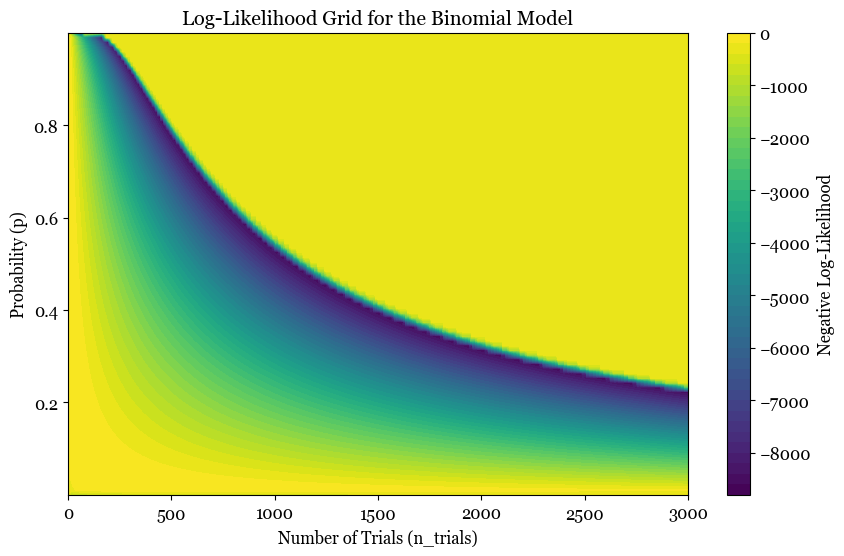

In [10]:
import numpy as np
from scipy.stats import binom

def fit_binom(y):
    # Define the negative log-likelihood function for the Binomial model
    def neg_log_likelihood_binom(params, y):
        n, p = params # Unpack the parameters
        pmf_values = binom.pmf(y, n, p)
        # Avoid log(0) by replacing 0 with a very small number
        pmf_values = np.where(np.array(pmf_values) == 0, 1e-10, pmf_values)
        result = -np.sum(np.log(pmf_values))
        return result

    # Define the grid of parameter ranges
    n_trials_range = np.arange(0, np.max(y)*200 + 1, 5)
    p_range = np.linspace(1e-5, 1 - 1e-5, 100)

    # Vectorized grid search for the best n and p
    n_grid, p_grid = np.meshgrid(n_trials_range, p_range, indexing='ij')
    log_likelihood_grid = np.zeros_like(n_grid, dtype=float)

    for i in range(n_grid.shape[0]):
        for j in range(n_grid.shape[1]):
            n = n_grid[i, j]
            p = p_grid[i, j]
            log_likelihood_grid[i, j] = -neg_log_likelihood_binom((np.array([n]),np.array([p])), np.array(y))
            pass

    # Mask out np.inf values by setting them to a very large number
    log_likelihood_grid[np.isinf(log_likelihood_grid)] = 1e10

    # Find the indices of the minimum negative log-likelihood
    min_idx = np.unravel_index(np.argmax(log_likelihood_grid), log_likelihood_grid.shape)
    n_fitted_binom = n_grid[min_idx]
    p_fitted_binom = p_grid[min_idx]
    best_neg_log_likelihood = log_likelihood_grid[min_idx]

    # Calculate the log-likelihood
    log_likelihood_binom = best_neg_log_likelihood

    # Number of parameters (k)
    k = 2

    # Number of data points (n)
    n = len(y)

    # Calculate BIC
    bic_binom = k * np.log(n) - 2 * log_likelihood_binom

    return log_likelihood_binom, n_fitted_binom, p_fitted_binom, bic_binom, n_grid, p_grid, log_likelihood_grid, neg_log_likelihood_binom

log_likelihood_binom, n_fitted_binom, p_fitted_binom, bic_binom, n_grid_binom, p_grid_binom, log_likelihood_grid_binom, _ = fit_binom(y)

print(f"Fitted n (number of trials): {n_fitted_binom}")
print(f"Fitted p (probability): {round(p_fitted_binom, 3)}")
print("BIC for the Binomial model:", int(bic_binom))

# Plot the log-likelihood grid
plt.figure(figsize=(10, 6))
plt.contourf(n_grid_binom, p_grid_binom, log_likelihood_grid_binom, levels=50, cmap='viridis')
plt.colorbar(label='Negative Log-Likelihood')
plt.xlabel('Number of Trials (n_trials)')
plt.ylabel('Probability (p)')
plt.title('Log-Likelihood Grid for the Binomial Model')
plt.show()

## Fitting a Negative Binomial

Fitted r (number of claims until stop): 7.1
Fitted p (probability of a claim): 0.51
BIC for the Negative Binomial model: 68


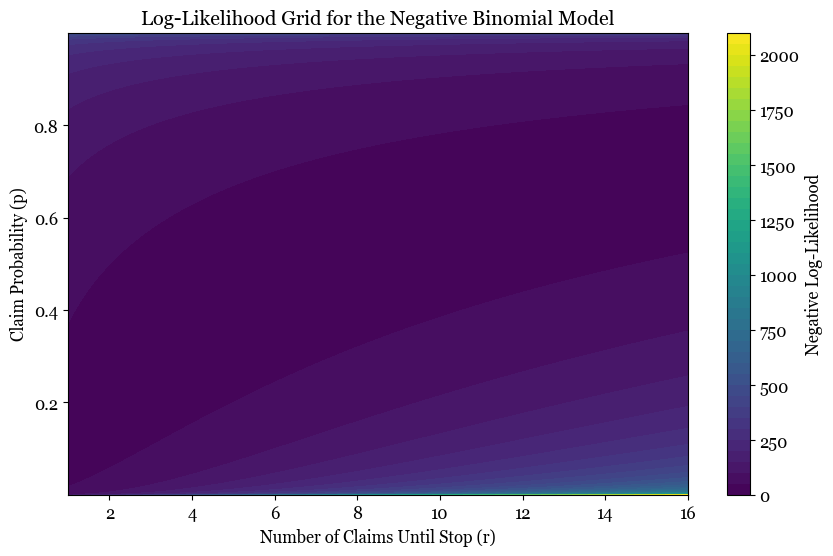

In [59]:
import numpy as np
from scipy.stats import nbinom
from scipy.optimize import minimize
from joblib import Parallel, delayed

def fit_nb(y):
    # Define the negative log-likelihood function for the Negative Binomial distribution
    def neg_log_likelihood_nb(params, y):
        r, p = params # Unpack the parameters
        pmf_values = nbinom.pmf(y, r, p)
        # Avoid log(0) by replacing 0 with a very small number
        pmf_values = np.where(np.array(pmf_values) == 0, 1e-10, pmf_values)
        result = -np.sum(np.log(pmf_values))
        return result

    # Define the grid of parameter ranges
    r_range = np.linspace(1, np.max(y) + 1, 100)  # Adjusted range for r
    p_range = np.linspace(1e-5, 1 - 1e-5, 1000)  # Adjusted range for p

    # Initialize an empty matrix to store the results
    log_likelihood_matrix = np.zeros((len(r_range), len(p_range)))

    # Function to perform optimization for a given r
    def optimize_for_r(i, r, y):
        best_p = None
        best_neg_log_likelihood = np.inf
        local_log_likelihood_matrix = np.zeros(len(p_range))
        for j, p in enumerate(p_range):
            initial_guess = np.array([r, p])
            result = neg_log_likelihood_nb(initial_guess, y)
            # result = minimize(neg_log_likelihood_nb, initial_guess, args=(y,), bounds=[(1e-5, None), (1e-5, 1-1e-5)])

            # Store the results in the local matrix
            local_log_likelihood_matrix[j] = result

            if result < best_neg_log_likelihood:
                best_neg_log_likelihood = result
                best_p = p
        return i, local_log_likelihood_matrix, r, best_p, best_neg_log_likelihood

    # Parallel processing to optimize for each r
    results = Parallel(n_jobs=-2)(delayed(optimize_for_r)(i, r, y) for (i, r) in enumerate(r_range))

    # Update the global log_likelihood_matrix with results from parallel processing
    for result in results:
        i, local_log_likelihood_matrix, r, best_p, best_neg_log_likelihood = result
        log_likelihood_matrix[i, :] = local_log_likelihood_matrix

    # Find the best parameters from the results
    best_result = min(results, key=lambda x: x[4])
    best_r, best_p, best_neg_log_likelihood = best_result[2], best_result[3], best_result[4]

    r_nb_fitted = best_r
    p_nb_fitted = best_p

    # Calculate the log-likelihood
    log_likelihood_nb = best_neg_log_likelihood

    # Number of parameters (k) and number of data points (n)
    k = 2
    n = len(y)

    # Calculate BIC
    bic_nb = k * np.log(n) + 2 * log_likelihood_nb

    return log_likelihood_nb, r_nb_fitted, p_nb_fitted, bic_nb, r_range, p_range, log_likelihood_matrix, neg_log_likelihood_nb

log_likelihood_nb, r_nb_fitted, p_nb_fitted, bic_nb, r_range_nb, p_range_nb, log_likelihood_matrix_nb, _ = fit_nb(y)

# Print the fitted parameters
print(f"Fitted r (number of claims until stop): {round(r_nb_fitted,1)}")
print(f"Fitted p (probability of a claim): {round(p_nb_fitted,2)}")
print("BIC for the Negative Binomial model:", int(bic_nb))

# Plot the log-likelihood grid
plt.figure(figsize=(10, 6))
plt.contourf(r_range_nb, p_range_nb, log_likelihood_matrix_nb.T, levels=50, cmap='viridis')
plt.colorbar(label='Negative Log-Likelihood')
plt.xlabel('Number of Claims Until Stop (r)')
plt.ylabel('Claim Probability (p)')
plt.title('Log-Likelihood Grid for the Negative Binomial Model')
plt.show()

## Fitting a Beta-Binomial

In [64]:
import numpy as np
from scipy.special import betaln, comb
from scipy.optimize import minimize

def fit_beta_binom(y):
    # Define the Beta-Binomial PMF
    def beta_binomial_pmf(k, n, alpha, beta):
        k = np.asarray(k)  # Ensure k is a numpy array
        binom_coeff = comb(n, k)  # Calculate the binomial coefficient
        pmf = binom_coeff * np.exp(betaln(k + alpha, n - k + beta) - betaln(alpha, beta))
        return pmf

    # Define the negative log-likelihood function for the Beta-Binomial distribution
    def neg_log_likelihood_bb(params, data):
        alpha, beta = params
        n = max(data)  # Assuming n is the maximal value in the data
        return -np.sum(np.log(beta_binomial_pmf(data, n, alpha, beta)))

    # Initial guesses for alpha and beta
    initial_params = [1, 1]

    # Fit the Beta-Binomial distribution to the data
    model_bb = minimize(neg_log_likelihood_bb, initial_params, args=(y,), bounds=[(1e-5, None), (1e-5, None)])

    # Extract the fitted parameters
    alpha_bb_fitted, beta_bb_fitted = model_bb.x

    # Calculate the log-likelihood of the model
    log_likelihood_bb = -neg_log_likelihood_bb((alpha_bb_fitted, beta_bb_fitted), y)

    # Number of parameters (k) and number of data points (n)
    k = 2
    n = len(y)

    # Calculate BIC
    bic_bb = k * np.log(n) - 2 * log_likelihood_bb

    return log_likelihood_bb, alpha_bb_fitted, beta_bb_fitted, bic_bb, beta_binomial_pmf, neg_log_likelihood_bb

log_likelihood_bb, alpha_bb_fitted, beta_bb_fitted, bic_bb, beta_binomial_pmf, _ = fit_beta_binom(y)

print(f"Fitted α (expected number of successes): {round(alpha_bb_fitted,1)}")
print(f"Fitted β (expected number of failures): {round(beta_bb_fitted,1)}")
print("BIC for the Beta-Binomial model:", int(bic_bb))

Fitted α (expected number of successes): 1.9
Fitted β (expected number of failures): 2.2
BIC for the Beta-Binomial model: 69


## Fitting the Empirical Distribution

In [103]:
import numpy as np
from collections import Counter

def fit_empirical(y):
    # Calculate the frequency of each value in the observed data
    frequency_counts = Counter(y)

    # Normalize the frequencies to get probabilities
    total_count = sum(frequency_counts.values())
    probabilities = {k: v / total_count for k, v in frequency_counts.items()}

    # Create the predictive distribution
    def predictive_distribution(value):
        return probabilities.get(value, 0)
    
    # Define the negative log-likelihood function for the Empirical distribution
    def neg_log_likelihood_emp(data):
        return -np.sum([np.log(predictive_distribution(val)) for val in data])

    # Calculate the log-likelihood of the observed data
    log_likelihood = -neg_log_likelihood_emp(y)

    # Number of parameters (k) and number of data points (n)
    k = len(y)
    n = len(y)

    # Calculate BIC
    bic_emp = k * np.log(n) - 2 * log_likelihood

    return log_likelihood, probabilities, bic_emp, predictive_distribution, neg_log_likelihood_emp

log_likelihood_emp, emp_probabilities, bic_emp, predictive_distribution, _ = fit_empirical(y)

print("BIC for the Empirical distribution:",  int(bic_emp))

BIC for the Empirical distribution: 83


## Model Averaging Using the Bayesian Information Criterion (BIC)

In [186]:
def bma_using_bic(model_names, param_counts, bic_values, pmf_values, train_data, test_data):
    """
    Perform Bayesian Model Averaging using BIC values and model probabilities.

    Parameters:
    model_names (list): List of model names.
    param_counts (list): List of the number of parameters for each model.
    bic_values (ndarray): Array of BIC values for each model.
    pmf_values (list): List of PMF values for each model.
    train_data (list): List of training data values.
    test_data (list): List of test data values.

    Returns:
    weights (ndarray): Array of weights for each model.
    average_pmf (ndarray): Weighted average of the PMF values.
    log_likelihood_bma (float): Log-likelihood of the averaged model.
    bic_averaged_model (float): BIC of the averaged model.
    """
    # Calculate the weights for each model based on their BIC values
    min_bic = np.min(bic_values)
    delta_bic = bic_values - min_bic
    weights = np.exp(-0.5 * delta_bic) / np.sum(np.exp(-0.5 * delta_bic))

    # Print the weights for each model
    print("Weights:")
    for i, name in enumerate(model_names):
        print(f" - {name} = {int(round(weights[i], 2)*100)}%")

    # Calculate the weighted average of the models
    average_pmf = np.zeros_like(pmf_values[0])
    for i, pmf in enumerate(pmf_values):
        average_pmf += weights[i] * np.array(pmf)

    # Calculate the log-likelihood of the averaged model on test data
    log_likelihood_bma = np.sum(np.log(average_pmf[test_data]))

    # Calculate the weighted average of the number of parameters
    num_parameters = np.sum(weights * param_counts)

    n = len(train_data) # Number of data points used to train the models

    # Calculate BIC
    bic_averaged_model = num_parameters * np.log(n) - 2 * log_likelihood_bma

    print(f"Number of parameters in the averaged model: {round(num_parameters,1)}")
    print(f"BIC of the averaged model: {int(bic_averaged_model)}")

    return weights, average_pmf, log_likelihood_bma, num_parameters, bic_averaged_model

# Define the model names
model_names = ['Uniform', 'Poisson', 'Binomial', 'Negative Binomial', 'Beta-Binomial', 'Empirical']

# Define the number of parameters for each model
param_counts = [1, 1, 2, 2, 2, len(y)]

# Define the BIC values for each model
bic_values = np.array([bic_uniform, bic_poi, bic_binom, bic_nb, bic_bb, bic_emp])

# Define the PMF values for each model
pmf_values = [uniform_pmf(x, n_fitted_uniform),
                poisson.pmf(x, mean_y),
                binom.pmf(x, n_fitted_binom, p_fitted_binom),
                nbinom.pmf(x, r_nb_fitted, p_nb_fitted),
                beta_binomial_pmf(x, max(y), alpha_bb_fitted, beta_bb_fitted),
                np.array([predictive_distribution(val) for val in x])]

# Perform Bayesian Model Averaging
weights, average_pmf, log_likelihood_bma, _, bic_averaged_model = bma_using_bic(model_names,
                                                                                param_counts,
                                                                                bic_values,
                                                                                pmf_values,
                                                                                y,
                                                                                y)


Weights:
 - Uniform = 41%
 - Poisson = 16%
 - Binomial = 4%
 - Negative Binomial = 25%
 - Beta-Binomial = 14%
 - Empirical = 0%
Number of parameters in the averaged model: 1.4
BIC of the averaged model: 66


## Visualizing the Different Models

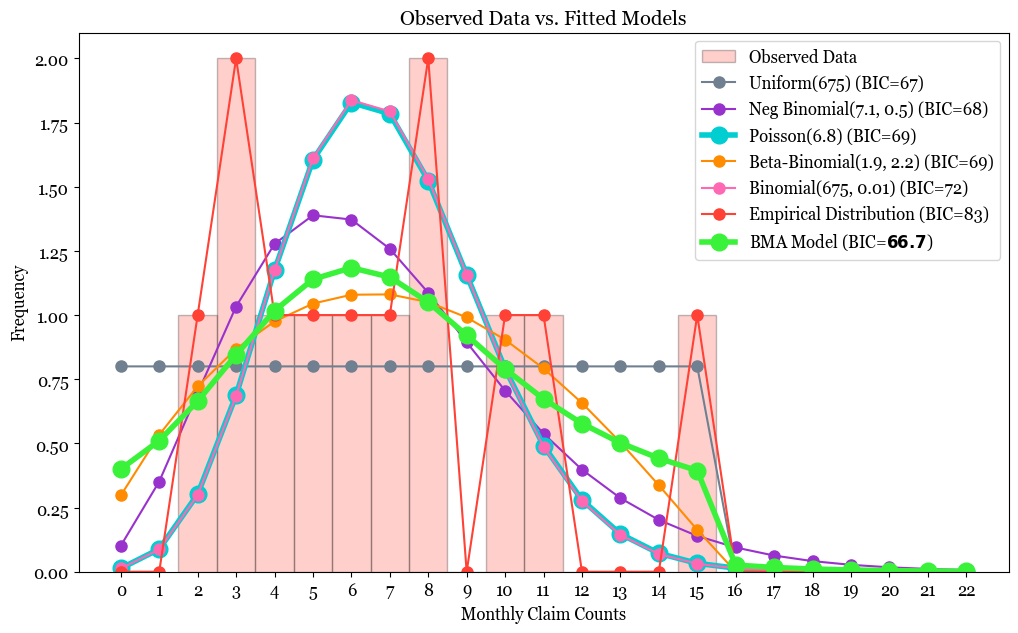

In [239]:
# Set the font properties
plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['font.size'] = 12

# Plot the observed data as a histogram
plt.figure(figsize=(12, 7))
plt.hist(y, bins=np.arange(min(y)-0.5, 21 + 1.5), alpha=0.25, color='#FF4136', edgecolor='black', label='Observed Data')

# Define data range
x = np.arange(0, int(max(y) * 1.5 + 1))

# Calculate the expected Uniform probabilities
uniform_pmf_values = uniform_pmf(x, n_fitted_uniform)
uniform_pmf_values = [x * len(y) for x in uniform_pmf_values]

# Overlay the fitted Uniform distribution
plt.plot(x, uniform_pmf_values, 'o-', label=f'Uniform({round(n_fitted_binom,1)}) (BIC={int(bic_uniform)})', color='#708090', markersize=8)

# Calculate the expected Negative Binomial probabilities
nbinom_pmf = nbinom.pmf(x, r_nb_fitted, p_nb_fitted) * len(y)

# Overlay the fitted Negative Binomial distribution
plt.plot(x, nbinom_pmf, 'o-', label=f'Neg Binomial({round(r_nb_fitted,1)}, {round(p_nb_fitted,1)}) (BIC={int(bic_nb)})', color='#9932CC', markersize=8)

# Overlay the fitted Poisson distribution
poisson_pmf = poisson.pmf(x, mean_y) * len(y)
plt.plot(x, poisson_pmf, 'o-', label=f'Poisson({round(mean_y,1)}) (BIC={int(bic_poi)})', color='#00CED1', markersize=12, linewidth=4)

# Calculate the expected Beta-Binomial probabilities
beta_binom_pmf = beta_binomial_pmf(x, max(y), alpha_bb_fitted, beta_bb_fitted) * len(y)

# Overlay the fitted Beta-Binomial distribution
plt.plot(x, beta_binom_pmf, 'o-', label=f'Beta-Binomial({round(alpha_bb_fitted,1)}, {round(beta_bb_fitted,1)}) (BIC={int(bic_bb)})', color='#FF8C00', markersize=8)

# Calculate the expected Binomial probabilities
binom_pmf = binom.pmf(x, n_fitted_binom, p_fitted_binom) * len(y)

# Overlay the fitted Binomial distribution
plt.plot(x, binom_pmf, 'o-', label=f'Binomial({n_fitted_binom}, {round(p_fitted_binom, 3)}) (BIC={int(bic_binom)})', color='#FF69B4', markersize=8)

# Calculate the empirical probabilities
empirical_pmf = np.array([emp_probabilities.get(val, 0) for val in x]) * len(y)

# Overlay the empirical distribution
plt.plot(x, empirical_pmf, 'o-', label=f'Empirical Distribution (BIC={int(bic_emp)})', color='#FF4136', markersize=8)

# Overlay the weighted average model
plt.plot(x, average_pmf * len(y), 'o-', label=f'BMA Model (BIC=$\\mathbf{{{round(bic_averaged_model, 1)}}}$)', color='#3BF23B', markersize=12, linewidth=4)

# Set x-axis labels for every element
plt.xticks(x)

plt.title('Observed Data vs. Fitted Models')
plt.xlabel('Monthly Claim Counts')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Cross-Validate to boost performance

In [188]:
from sklearn.model_selection import KFold

def calc_BIC(log_likelihood, k, n):
    """
    Calculate the Bayesian Information Criterion (BIC) from the log-likelihood, number of parameters, and number of data points.
    
    Parameters:
    - log_likelihood: Log-likelihood of the model.
    - k: Number of parameters in the model.
    - n: Number of data points used to fit the model.
    
    Returns:
    - bic: Bayesian Information Criterion (BIC) value.
    """
    bic = k * np.log(n) - 2 * log_likelihood
    return bic

def model_func(train_data, test_data, x):
    """
    Example model function. Replace with actual model training and evaluation.
    
    Parameters:
    - train_data: Training data.
    - test_data: Testing data.
    - x: Values for the PMF.
    
    Returns:
    - performance: Performance metric (e.g., accuracy, log-likelihood).
    """
    # Fit the Uniform distribution to the training data
    _, n_fitted_uniform, _, uniform_pmf, neg_log_likelihood_uniform = fit_uniform(train_data)
    test_log_likelihood_uni = -neg_log_likelihood_uniform([n_fitted_uniform], test_data)
    bic_uni = calc_BIC(test_log_likelihood_uni, 1, len(train_data))

    # Fit the Poisson distribution to the training data
    _, λ, _, neg_log_likelihood_poi = fit_poi(train_data)
    test_log_likelihood_poi = -neg_log_likelihood_poi(λ, test_data)
    bic_poi = calc_BIC(test_log_likelihood_poi, 1, len(train_data))

    # Fit the Binomial distribution to the training data
    _, n_fitted_binom, p_fitted_binom, _, _, _, _, neg_log_likelihood_binom = fit_binom(train_data)
    test_log_likelihood_binom = -neg_log_likelihood_binom((np.array([n_fitted_binom]),np.array([p_fitted_binom])), test_data)
    bic_binom = calc_BIC(test_log_likelihood_binom, 2, len(train_data))

    # Fit the Negative Binomial distribution to the training data
    _, r_nb_fitted, p_nb_fitted, _, _, _, _, neg_log_likelihood_nb = fit_nb(train_data)
    test_log_likelihood_nb = -neg_log_likelihood_nb((r_nb_fitted, p_nb_fitted), test_data)
    bic_nb = calc_BIC(test_log_likelihood_nb, 2, len(train_data))

    # Fit the Beta-Binomial distribution to the training data
    _, alpha_bb_fitted, beta_bb_fitted, _, beta_binomial_pmf, neg_log_likelihood_bb = fit_beta_binom(train_data)
    test_log_likelihood_bb = -neg_log_likelihood_bb((alpha_bb_fitted, beta_bb_fitted), test_data)
    bic_bb = calc_BIC(test_log_likelihood_bb, 2, len(train_data))

    # Won't bother fitting the Empirical distribution since it won't factor into the blended model
    
    # Define the model names
    model_names = ['Uniform', 'Poisson', 'Binomial', 'Negative Binomial', 'Beta-Binomial']

    # Define the number of parameters for each model
    param_counts = [1, 1, 2, 2, 2]

    # Define the BIC values for each model
    bic_values = np.array([bic_uni, bic_poi, bic_binom, bic_nb, bic_bb])

    # Define the PMF values for each model
    pmf_values = [uniform_pmf(x, n_fitted_uniform),
                    poisson.pmf(x, mean_y),
                    binom.pmf(x, n_fitted_binom, p_fitted_binom),
                    nbinom.pmf(x, r_nb_fitted, p_nb_fitted),
                    beta_binomial_pmf(x, max(y), alpha_bb_fitted, beta_bb_fitted)]

    # Perform Bayesian Model Averaging
    weights, average_pmf, log_likelihood_bma, num_params_bma, bic_averaged_model = bma_using_bic(model_names,
                                                                                                    param_counts,
                                                                                                    bic_values,
                                                                                                    pmf_values,
                                                                                                    train_data,
                                                                                                    test_data)

    return weights, average_pmf, log_likelihood_bma, num_params_bma, bic_averaged_model

def cross_validate(model_func, data, x, k=5):
    """
    Perform k-fold cross-validation on the given model function and data.
    
    Parameters:
    - model_func: Function to train and evaluate the model. Should return a performance metric.
    - data: The dataset to perform cross-validation on.
    - k: Number of folds for cross-validation.
    
    Returns:
    - mean_performance: Mean performance metric across all folds.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    model_names = []
    param_counts = []
    bic_values = []
    pmf_values = []

    model_uncertainty = [] # Track uncertainty of the individual models

    for fold_number, (train_index, test_index) in enumerate(kf.split(data), 1):
        print(f"Evaluating Fold {fold_number}")
        train_data = [data[i] for i in train_index]
        test_data = [data[i] for i in test_index]
        weights, average_pmf, log_likelihood_bma, params_averaged_model, bic_averaged_model = model_func(train_data, test_data, x)
        model_uncertainty.append(weights)

        # Store the results of BMA for each fold
        model_names.append(f"BMA Model from Fold {fold_number}")
        param_counts.append(params_averaged_model)
        bic_values.append(bic_averaged_model)
        pmf_values.append(average_pmf)

    # Perform BMA of the fold models
    weights_bma_cv, average_pmf_bma_cv, log_likelihood_bma_cv, param_num_bma_cv, bic_bma_cv = bma_using_bic(model_names,
                                                                                                            param_counts,
                                                                                                            bic_values,
                                                                                                            pmf_values,
                                                                                                            train_data,
                                                                                                            test_data)
    return weights_bma_cv, average_pmf_bma_cv, log_likelihood_bma_cv, param_num_bma_cv, bic_bma_cv, model_uncertainty

# Define data range
x = np.arange(0, int(max(y) * 1.5 + 1))

# Perform cross-validation
weights_bma_cv, average_pmf_bma_cv, log_likelihood_bma_cv, param_num_bma_cv, bic_bma_cf, model_uncertainty = cross_validate(model_func, y, x, k=len(y))
print("Weighted performance across all folds:", round(bic_bma_cf, 1))

Evaluating Fold 1
Weights:
 - Uniform = 32%
 - Poisson = 23%
 - Binomial = 7%
 - Negative Binomial = 11%
 - Beta-Binomial = 28%
Number of parameters in the averaged model: 1.5
BIC of the averaged model: 8
Evaluating Fold 2
Weights:
 - Uniform = 21%
 - Poisson = 47%
 - Binomial = 14%
 - Negative Binomial = 10%
 - Beta-Binomial = 7%
Number of parameters in the averaged model: 1.3
BIC of the averaged model: 7
Evaluating Fold 3
Weights:
 - Uniform = 35%
 - Poisson = 10%
 - Binomial = 3%
 - Negative Binomial = 6%
 - Beta-Binomial = 46%
Number of parameters in the averaged model: 1.6
BIC of the averaged model: 9
Evaluating Fold 4
Weights:
 - Uniform = 25%
 - Poisson = 46%
 - Binomial = 14%
 - Negative Binomial = 10%
 - Beta-Binomial = 5%
Number of parameters in the averaged model: 1.3
BIC of the averaged model: 7
Evaluating Fold 5
Weights:
 - Uniform = 22%
 - Poisson = 43%
 - Binomial = 13%
 - Negative Binomial = 11%
 - Beta-Binomial = 10%
Number of parameters in the averaged model: 1.3
BIC 

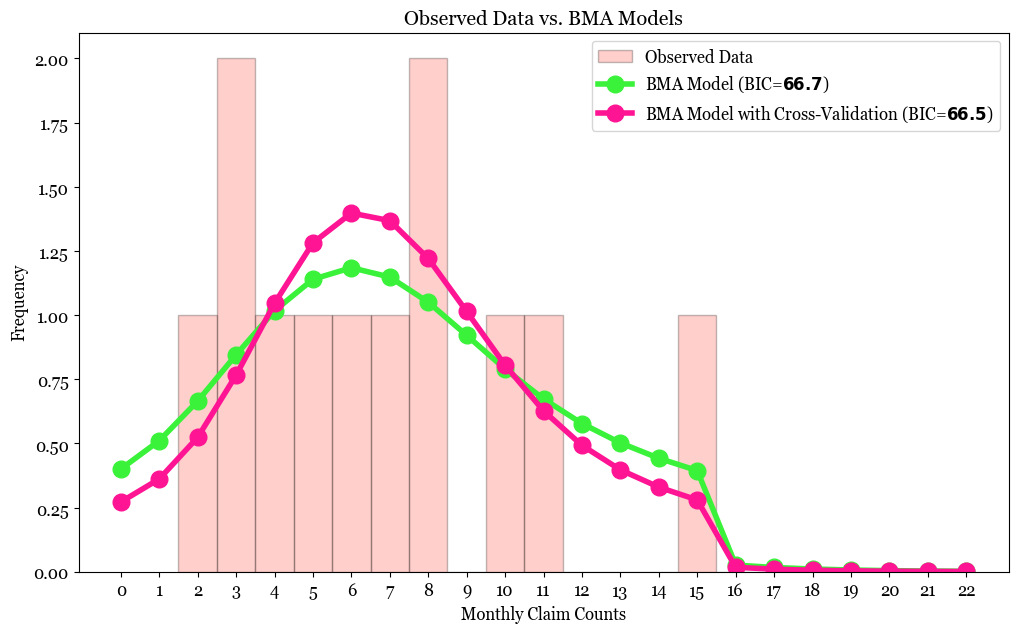

In [237]:
# Define data range
x = np.arange(0, int(max(y) * 1.5 + 1))

# Evaluate BIC for the BMA Cross-Validation Model
bic_bma_cv = round(calc_BIC(np.sum(np.log(average_pmf[y])), param_num_bma_cv, len(y)),2)

# Plot the average BMA Cross-Validation model
plt.figure(figsize=(12, 7))
plt.hist(y, bins=np.arange(min(y)-0.5, 21 + 1.5), alpha=0.25, color='#FF4136', edgecolor='black', label='Observed Data')

# Overlay the weighted average model
plt.plot(x, average_pmf * len(y), 'o-', label=f'BMA Model (BIC=$\\mathbf{{{round(bic_averaged_model, 1)}}}$)', color='#3BF23B', markersize=12, linewidth=4)

# Overlay the weighted average model
plt.plot(x, average_pmf_bma_cv * len(y), 'o-', label=f'BMA Model with Cross-Validation (BIC=$\\mathbf{{{round(bic_bma_cv,1)}}}$)', color='#FF1493', markersize=12, linewidth=4)

# Set x-axis labels for every element
plt.xticks(x)

plt.title('Observed Data vs. BMA Models')
plt.xlabel('Monthly Claim Counts')
plt.ylabel('Frequency')
plt.legend()
plt.show()


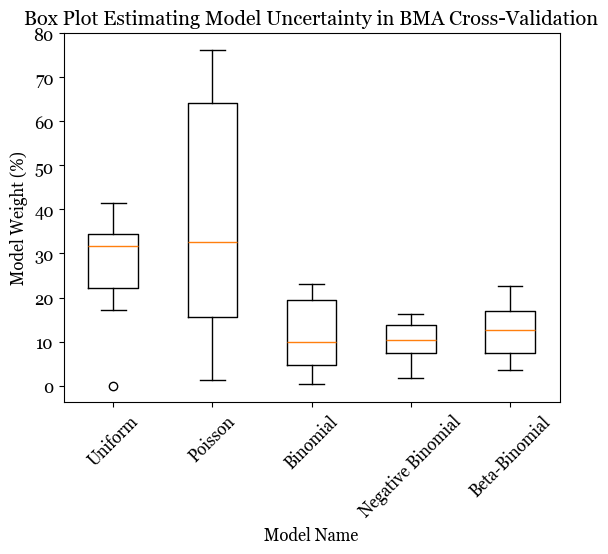

In [238]:
model_names_cv = model_names[:-1] # only use the models fitted in the cross-validation
# print(weights_bma_cv) # BMA weight for each cross-validated fold
# average_pmf_bma_cv
# log_likelihood_bma_cv
# param_num_bma_cv
# bic_bma_cf
# print(model_uncertainty) # Weight of the individual component models in each BMA fold

# Get the weight of the individual component models in each fold, weighted by the BMA fit
# Multiply each column of the arrays by the respective elements in the array
result = [x * y for x, y in zip(weights_bma_cv, model_uncertainty)]

assert np.round(np.sum(result),4) == 1

result = np.array(result).reshape(len(weights_bma_cv), len(model_names_cv))

# Scale the weights by the number of folds to get the total weight of each model
result *= len(weights_bma_cv) * 100 # Multiply by 100 to get percentage

# Create the box plot
plt.boxplot(result)

# Label the axes
plt.xlabel('Model Name')
plt.ylabel('Model Weight (%)')
plt.title('Box Plot Estimating Model Uncertainty in BMA Cross-Validation')

# Optionally, set the x-ticks to the model names
plt.xticks(ticks=np.arange(1, len(model_names_cv) + 1), labels=model_names_cv, rotation=45)

# Show the plot
plt.show()